# University of Iowa Inverted Pendulum Educational Display
### Control Simulations
Author: Will Martin

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
import numpy as np
import control

In [10]:
# SETUP

# constants
mass_cart = 0.31
mass_pendulum = 0.1
L = 0.25
J = mass_pendulum*(L**2)
g = 9.81
linear_thesh = math.pi/9

In [11]:
# LINEAR X-BOUNDING CONTROLLER GAIN

# linear dynamics of cart w/o pendulum
A = np.array([[0, 1],
              [0, 0]])
B = np.array([[0],
              [1]])

# pole placement
p = np.array([-1, -2])

# feedback gains
K_linear_bound = control.place(A, B, p)
print(K_linear_bound)

[[2. 3.]]


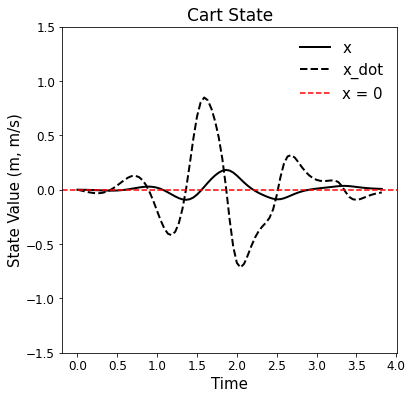

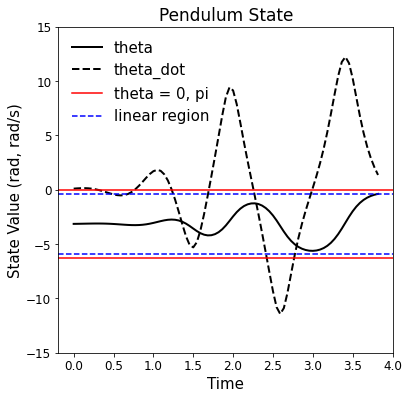

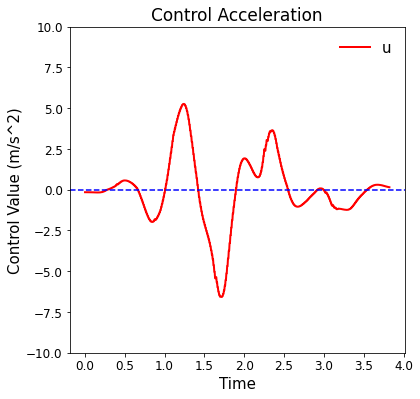

In [12]:
# NONLINEAR CONTROLLER + LINEAR X-BOUNDING CONTROLLER

u_array = []

def f_nonlinear(state_vector, t):
    # states
    x, x_dot, theta, theta_dot = state_vector
    
    E_0 = 0
    E = (1/2)*J*(theta_dot**2)+mass_pendulum*g*L*(math.cos(theta)-1)
    
    # controller
    k = 3.1
    u = -k*(E-E_0)*theta_dot*math.cos(theta) - K_linear_bound@[x, x_dot]
    
    u_array.append(u)
        
    return [x_dot, u, theta_dot, ((mass_pendulum*L*math.cos(theta)*u)+(mass_pendulum*g*L*math.sin(theta)))/J]

# initial conditions
t0 = 0.0
x0 = [0, 0, -math.pi, 0.1]

# solve IVP
t1 = t0 + 4.5
n = 100
t = np.linspace(t0, t1, n)
sol = odeint(f_nonlinear, x0, t)

# time system enter linear region
idx_linear = np.argmax((sol[:,2] > -linear_thesh) | (sol[:,2] < -(2*math.pi)+linear_thesh))
t_linear = idx_linear * (t1-t0)/n
state_linear = sol[idx_linear]

# truncate solution
sol = sol[:idx_linear,:]
t = t[:idx_linear]

# plot cart state
plt.figure(figsize=(6,6))
plt.title("Cart State", fontsize=17)
plt.ylim(-1.5, 1.5)
plt.plot(t, sol[:,0], 'k-', label='x', linewidth =2)
plt.plot(t, sol[:,1], 'k--', label='x_dot', linewidth =2)
plt.axhline(y=0, color='r', linestyle='--', label= 'x = 0')

plt.legend( loc='best', scatterpoints=1,  fontsize=15, frameon=False, labelspacing=0.5)
plt.ylabel("State Value (m, m/s)", size=15)
plt.xlabel('Time', size=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# plot pendulum state
plt.figure(figsize=(6,6))
plt.title("Pendulum State", fontsize=17)
plt.ylim(-15, 15)
plt.plot(t, sol[:,2], 'k-', label='theta', linewidth =2)
plt.plot(t, sol[:,3], 'k--', label='theta_dot', linewidth =2)
plt.axhline(y=0, color='r', linestyle='-', label='theta = 0, pi')
plt.axhline(y=-linear_thesh, color='b', linestyle='--', label='linear region')
plt.axhline(y=-(2*math.pi), color='r', linestyle='-')
plt.axhline(y=-(2*math.pi)+linear_thesh, color='b', linestyle='--')


plt.legend( loc='best', scatterpoints=1,  fontsize=15, frameon=False, labelspacing=0.5)
plt.ylabel("State Value (rad, rad/s)", size=15)
plt.xlabel('Time', size=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# plot control force

# u is calculated more often than the solution so do some funky stuff to get the correct range
t_u = [_t for _t in np.linspace(t0, t1, len(u_array)) if _t < t_linear]
u = u_array[:len(t_u)]

plt.figure(figsize=(6,6))
plt.title("Control Acceleration", fontsize=17)
plt.ylim(-10, 10)
plt.plot(t_u, u, 'r', label='u', linewidth =2)
plt.axhline(y=0, color='b', linestyle='--')
plt.legend( loc='best', scatterpoints=1,  fontsize=15, frameon=False, labelspacing=0.5)
plt.ylabel("Control Value (m/s^2)", size=15)
plt.xlabel('Time', size=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [13]:
# LINEAR CONTROLLER GAIN

A = np.array([[0,1,0,0],
              [0,0,0,0],
              [0,0,0,1],
              [0,0,(mass_pendulum*g*L)/J,0]])
B = np.array([[0],
              [1],
              [0],
              [(mass_pendulum*L)/J]])
Q = np.array([[1,0,0,0],
              [0,1,0,0],
              [0,0,10,0],
              [0,0,0,1]])
R = np.array([1])

K_linear, _, _ = control.lqr(A, B, Q, R)
print(K_linear)

[[-1.         -2.08166964 26.16007443  4.26441757]]


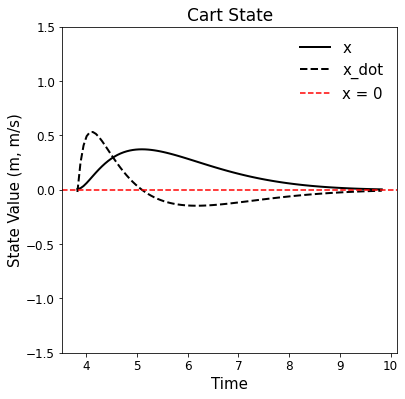

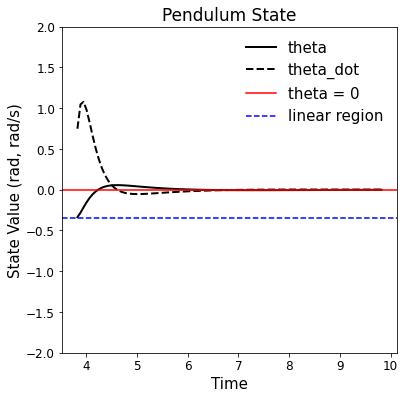

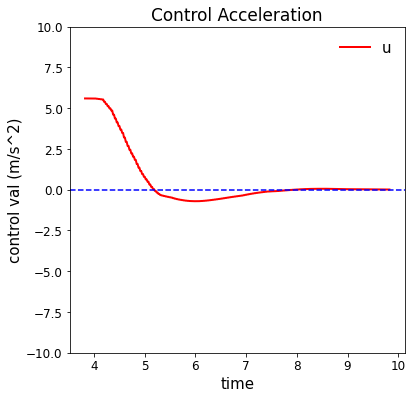

In [14]:
# LINEAR CONTROLLER

u_array = []

def f_linear(state_vector, t):
    # states
    x, x_dot, theta, theta_dot = state_vector
    
    # controller
    u = -K_linear@np.array([[x], [x_dot], [theta], [theta_dot]])
    
    u_array.append(u)

    return [x_dot, u, theta_dot, ((mass_pendulum*L*math.cos(theta)*u)+(mass_pendulum*g*L*math.sin(theta)))/J]

# initial conditions
t0 = t_linear
x0 = state_linear

# solve IVP
t1 = t0 + 6
n = 100
t = np.linspace(t0, t1, n)
sol = odeint(f_linear, x0, t)

# plot cart state
plt.figure(figsize=(6,6))
plt.title("Cart State", fontsize=17)
plt.ylim(-1.5, 1.5)
plt.plot(t, sol[:,0], 'k-', label='x', linewidth =2)
plt.plot(t, sol[:,1], 'k--', label='x_dot', linewidth =2)
plt.axhline(y=0, color='r', linestyle='--', label= 'x = 0')

plt.legend( loc='best', scatterpoints=1,  fontsize=15, frameon=False, labelspacing=0.5)
plt.ylabel("State Value (m, m/s)", size=15)
plt.xlabel('Time', size=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# plot pendulum state
plt.figure(figsize=(6,6))
plt.title("Pendulum State", fontsize=17)
plt.ylim(-2, 2)
plt.plot(t, sol[:,2], 'k-', label='theta', linewidth =2)
plt.plot(t, sol[:,3], 'k--', label='theta_dot', linewidth =2)
plt.axhline(y=0, color='r', linestyle='-', label='theta = 0')
plt.axhline(y=-linear_thesh, color='b', linestyle='--', label='linear region')
plt.axhline(y=-(2*math.pi), color='r', linestyle='-')
plt.axhline(y=-(2*math.pi)+linear_thesh, color='b', linestyle='--')

plt.legend( loc='best', scatterpoints=1,  fontsize=15, frameon=False, labelspacing=0.5)
plt.ylabel("State Value (rad, rad/s)", size=15)
plt.xlabel('Time', size=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# plot control acceleration
plt.figure(figsize=(6,6))
plt.title("Control Acceleration", fontsize=17)
plt.ylim(-10, 10)
plt.plot(np.linspace(t0, t1, len(u_array)), np.array(u_array).flatten(), 'r', label='u', linewidth =2)
plt.axhline(y=0, color='b', linestyle='--')
plt.legend( loc='best', scatterpoints=1,  fontsize=15, frameon=False, labelspacing=0.5)
plt.ylabel("control val (m/s^2)", size=15)
plt.xlabel('time', size=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()